<a href="https://colab.research.google.com/github/Chanura04/ML-Coursework/blob/main/20240955.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install keras-tuner

In [2]:
import pandas as pd
# from google.colab import drive
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, accuracy_score
import keras_tuner as kt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras import layers, regularizers
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (
    StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, classification_report, confusion_matrix
)

## Load the dataset

In [3]:
url = "https://raw.githubusercontent.com/Chanura04/ML-Coursework/main/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv"

## Check dataset behaviour

In [4]:
df=pd.read_csv(url)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 21)

## Data Preprocessing

In [6]:
categorical_cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod',"Churn"]
numerical_cols=['MonthlyCharges','TotalCharges','tenure']

In [7]:
categorical_cols

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [8]:
numerical_cols

['MonthlyCharges', 'TotalCharges', 'tenure']

In [9]:
df_cp=df.copy()

In [10]:
df_cp = df_cp.drop(columns=['customerID'])
df_cp.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [11]:
len(df_cp.columns)

20

In [12]:
df_cp.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [13]:
df_cp["SeniorCitizen"].isnull().sum()


np.int64(0)

In [14]:
df_cp.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [20]:
def convert_to_numeric(value):
    try:
        return float(value)
    except ValueError:
        return None

df_cp['TotalCharges'] = df_cp['TotalCharges'].apply(convert_to_numeric)

In [21]:
df_cp['TotalCharges']=df_cp['TotalCharges'].fillna(df_cp['TotalCharges'].median())

In [22]:
df_cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [23]:
for col in df_cp.columns:
  # print(col)
  value=df_cp[col].value_counts()
  print(value)
  print('*'*50)
  print("\n")

gender
Male      3555
Female    3488
Name: count, dtype: int64
**************************************************


SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
**************************************************


Partner
No     3641
Yes    3402
Name: count, dtype: int64
**************************************************


Dependents
No     4933
Yes    2110
Name: count, dtype: int64
**************************************************


tenure
1     613
72    362
2     238
3     200
4     176
     ... 
28     57
39     56
44     51
36     50
0      11
Name: count, Length: 73, dtype: int64
**************************************************


PhoneService
Yes    6361
No      682
Name: count, dtype: int64
**************************************************


MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
**************************************************


InternetService
Fiber optic    3096
DSL            242

In [24]:
for col in df_cp.columns:
  print("\n")
  print(col)
  print(df_cp[col].unique())

  print("\n")
  print('*'*50)




gender
['Female' 'Male']


**************************************************


SeniorCitizen
[0 1]


**************************************************


Partner
['Yes' 'No']


**************************************************


Dependents
['No' 'Yes']


**************************************************


tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


**************************************************


PhoneService
['No' 'Yes']


**************************************************


MultipleLines
['No phone service' 'No' 'Yes']


**************************************************


InternetService
['DSL' 'Fiber optic' 'No']


**************************************************


OnlineSecurity
['No' 'Yes' 'No internet service']


**************************************************


OnlineBackup
['Ye

In [25]:
# In this dataset there are some features both represent same meaning.Here i convert those to one
df_cp['MultipleLines'] = df_cp['MultipleLines'].replace('No phone service', 'No')
df_cp[['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
      'TechSupport', 'StreamingTV', 'StreamingMovies']] = df_cp[['OnlineSecurity', 'OnlineBackup',
                                                                'DeviceProtection', 'TechSupport',
                                                                'StreamingTV', 'StreamingMovies']].replace('No internet service', 'No')

In [26]:
df_cp

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


In [27]:
# SeniorCitizen is a binary categorical feature
categorical_cols=['gender','SeniorCitizen','Partner','Dependents','PhoneService','MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaperlessBilling','PaymentMethod',"Churn"]
numerical_cols=['MonthlyCharges','TotalCharges','tenure']
len(categorical_cols)

17

In [28]:
label_encoding_columns=['gender','Partner','Dependents','PhoneService','PaperlessBilling','Churn','MultipleLines','OnlineSecurity','OnlineBackup',
                        'DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

one_hot_encoding_columns=['InternetService','Contract','PaymentMethod']

len(label_encoding_columns)+len(one_hot_encoding_columns)

16

<Axes: >

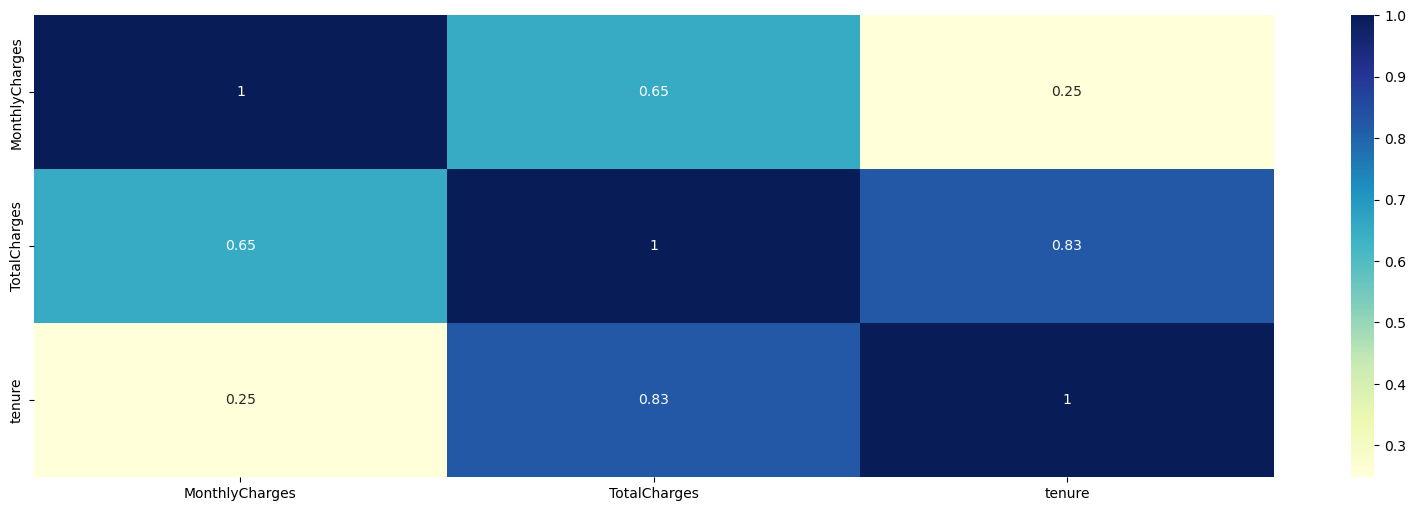

In [29]:
plt.figure(figsize=(20, 6))
sns.heatmap(df_cp[numerical_cols].corr(), cmap = 'YlGnBu', annot = True)

#### Label Encoding

In [30]:
#Label encoding method use for binary categories
l_encoder=LabelEncoder()

for col in label_encoding_columns:
  df_cp[col]=l_encoder.fit_transform(df_cp[col])

In [31]:
df_cp.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,0,DSL,0,1,0,0,0,0,Month-to-month,1,Electronic check,29.85,29.85,0
1,1,0,0,0,34,1,0,DSL,1,0,1,0,0,0,One year,0,Mailed check,56.95,1889.50,0
2,1,0,0,0,2,1,0,DSL,1,1,0,0,0,0,Month-to-month,1,Mailed check,53.85,108.15,1
3,1,0,0,0,45,0,0,DSL,1,0,1,1,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0
4,0,0,0,0,2,1,0,Fiber optic,0,0,0,0,0,0,Month-to-month,1,Electronic check,70.70,151.65,1


#### One-Hot Encoding

In [32]:
#One-Hot encoder use for multi class categories
oneHot_encoder=OneHotEncoder(sparse_output=False,drop=None)
encoded_data=oneHot_encoder.fit_transform(df_cp[one_hot_encoding_columns])
oneHot_encoded_df=pd.DataFrame(encoded_data,columns=oneHot_encoder.get_feature_names_out(one_hot_encoding_columns))

In [33]:
df_cp_final=df_cp.drop(columns=one_hot_encoding_columns)
df_cp_final=pd.concat([df_cp_final,oneHot_encoded_df],axis=1)
df_cp_final.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
df_cp_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 27 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   gender                                   7043 non-null   int64  
 1   SeniorCitizen                            7043 non-null   int64  
 2   Partner                                  7043 non-null   int64  
 3   Dependents                               7043 non-null   int64  
 4   tenure                                   7043 non-null   int64  
 5   PhoneService                             7043 non-null   int64  
 6   MultipleLines                            7043 non-null   int64  
 7   OnlineSecurity                           7043 non-null   int64  
 8   OnlineBackup                             7043 non-null   int64  
 9   DeviceProtection                         7043 non-null   int64  
 10  TechSupport                              7043 no

In [35]:
for col in df_cp.columns:
  print("\n")
  print(col)
  print(df_cp[col].unique())

  print("\n")
  print('*'*50)



gender
[0 1]


**************************************************


SeniorCitizen
[0 1]


**************************************************


Partner
[1 0]


**************************************************


Dependents
[0 1]


**************************************************


tenure
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]


**************************************************


PhoneService
[0 1]


**************************************************


MultipleLines
[0 1]


**************************************************


InternetService
['DSL' 'Fiber optic' 'No']


**************************************************


OnlineSecurity
[0 1]


**************************************************


OnlineBackup
[1 0]


**************************************************


DeviceProtection
[0 1]


******

In [36]:
df_cp_final['Churn'].value_counts()

Churn
0    5174
1    1869
Name: count, dtype: int64

In [37]:
df_cp_final.isnull().sum()

gender                                     0
SeniorCitizen                              0
Partner                                    0
Dependents                                 0
tenure                                     0
PhoneService                               0
MultipleLines                              0
OnlineSecurity                             0
OnlineBackup                               0
DeviceProtection                           0
TechSupport                                0
StreamingTV                                0
StreamingMovies                            0
PaperlessBilling                           0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
Contract_Month-to-month                    0
Contract_One year                          0
Contract_T

In [38]:
X=df_cp_final.drop(columns=['Churn'],axis=1)
y=df_cp_final['Churn']


In [39]:
X

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,0,0,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,0,0,0,34,1,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1,0,0,0,2,1,0,1,1,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,0,0,0,45,0,0,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,0,0,0,0,2,1,0,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,0,1,1,24,1,1,1,0,1,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
7039,0,0,1,1,72,1,1,0,1,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7040,0,0,1,1,11,0,0,1,0,0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7041,1,1,1,0,4,1,1,0,0,0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
y

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int64

In [42]:
X.to_csv("dataset/processed/X.csv", index=False)
y.to_csv("dataset/processed/y_data.csv", index=False)
